# NN (MLP) - CV 0.670 - LB 0.670
In this notebook, we present a Neural Network NN (MLP) baseline. This NN is very fast to train on GPU! We achieve CV 0.670. There is a discussion about this notebook [here][7]

We tranform the two train targets (`efs` and `efs_time`) into a single target (`y`) and then train regression NN with MSE loss. We load Kaggle's official metric code from [here][1] and evaluate the CV performance using competition metric Stratified Concordance Index.

In this comp, we need to predict `risk score`. There are many different ways to transform the two train targets into a value that mimics `risk score` and train an NN (or any other regression model like SVR) with regression. I present one transformation in this notebook and I presented a different one in my XGBoost starter notebook [here][3]. 

Consider experimenting by creating your own target from `efs` and `efs_time`. Or considering using survival loss directly which uses both `efs` and `efs_time` as explained in discussion post [here][4]. Kaggle user MT describes another transformation [here][5] called `KaplanMeierFitter` and gives an example [here][6]

Good luck, have fun!

[1]: https://www.kaggle.com/code/metric/eefs-concordance-index
[2]: https://www.kaggle.com/competitions/equity-post-HCT-survival-predictions/discussion/550003
[3]: https://www.kaggle.com/code/cdeotte/xgboost-catboost-baseline-cv-668-lb-668
[4]: https://www.kaggle.com/competitions/equity-post-HCT-survival-predictions/discussion/550141
[5]: https://www.kaggle.com/competitions/equity-post-HCT-survival-predictions/discussion/550141#3064661
[6]: https://www.kaggle.com/competitions/equity-post-HCT-survival-predictions/discussion/550337
[7]: https://www.kaggle.com/competitions/equity-post-HCT-survival-predictions/discussion/550343

# Pip Install Libraries for Metric
Since internet must be turned off for submission, we pip install from my other notebook [here][1] where I downloaded the WHL files.

[1]: https://www.kaggle.com/code/cdeotte/pip-install-lifelines

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [ ]:
!pip install /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
!pip install /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl

## Step 1: Imports

In [3]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, Embedding
from tensorflow.keras.layers import Concatenate, BatchNormalization
import tensorflow.keras.backend as K
from sklearn.model_selection import KFold

print('TF Version',tf.__version__)

TF Version 2.16.1


## Step 2 :  Load Train and Test

In [4]:

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

test = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/test.csv")
print("Test shape:", test.shape )

train = pd.read_excel("/kaggle/input/cibmtr-2024-dataset/random_folding.xlsx")
print("Train shape:",train.shape)
train.head()

Test shape: (3, 58)
Train shape: (28800, 61)


,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time,fold
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,Bone marrow,No,No,No,IEA,6.0,+/+,NaN,2.0,NaN,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2016,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,9.942,2.0,FKalone,No,M-F,2.0,More than one race,0.0,90.0,No,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0,42.356,3
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,Peripheral blood,No,No,No,AML,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,PB,Intermediate,MAC,Not Hispanic or Latino,2008,No,Positive,No,Permissive,2.0,No,72.29,No,2.0,No,43.705,2.0,Other GVHD Prophylaxis,No,F-F,2.0,Asian,3.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1,4.672,7
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,HIS,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2019,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,33.997,2.0,Cyclophosphamide alone,No,F-M,2.0,More than one race,0.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0,19.793,6
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,ALL,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,Intermediate,MAC,Not Hispanic or Latino,2009,No,Positive,No,Permissive,2.0,No,29.23,No,2.0,No,43.245,2.0,FK+ MMF +- others,No,M-M,2.0,White,0.0,90.0,Yes,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0,102.349,1
4,4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,Peripheral blood,No,No,No,MPN,6.0,+/+,10.0,2.0,NaN,5.0,2.0,No,2.0,2.0,PB,NaN,MAC,Hispanic or Latino,2018,No,NaN,Yes,NaN,2.0,No,56.81,No,2.0,No,29.740,2.0,TDEPLETION +- other,No,M-F,2.0,American Indian or Alaska Native,1.0,90.0,No,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0,16.223,4


## Step 3: EDA on Train Targets
There are two train targets `efs` and `efs_time`. When `efs==1` we know patient **had an event** and we know time of event is `efs_time`. When `efs==0` we **do not know** if patient had an event or not, but we do know that patient was **without event for at least** `efs_time`.

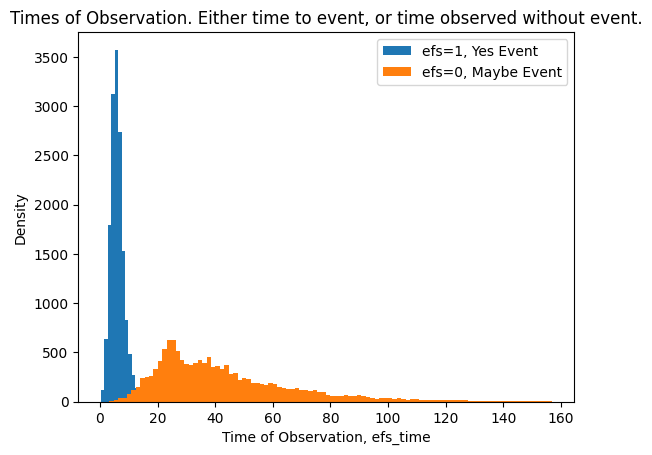

In [5]:
plt.hist(train.loc[train.efs==1,"efs_time"],bins=100,label="efs=1, Yes Event")
plt.hist(train.loc[train.efs==0,"efs_time"],bins=100,label="efs=0, Maybe Event")
plt.xlabel("Time of Observation, efs_time")
plt.ylabel("Density")
plt.title("Times of Observation. Either time to event, or time observed without event.")
plt.legend()
plt.show()

## Step 4: Transform Two Train Targets into One Target!
Both targets `efs` and `efs_time` provide useful information. We will tranform these two targets into a single target to train our model with. In this competition we need to predict `risk score`. So we will create a target that mimics `risk score` to train our model. (Note this is only one out of many ways to transform two targets into one target. Considering experimenting on your own).

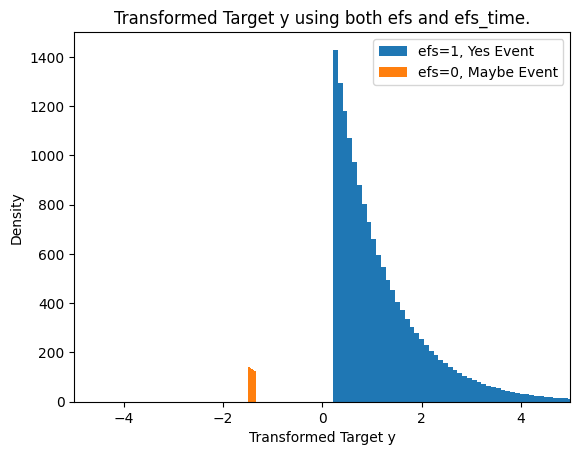

In [6]:
train["y"] = train.efs_time.values
mx = train.loc[train.efs==1,"efs_time"].max()
mn = train.loc[train.efs==0,"efs_time"].min()
train.loc[train.efs==0,"y"] = train.loc[train.efs==0,"y"] + mx - mn
train.y = train.y.rank()
train.loc[train.efs==0,"y"] += 2*len(train)
train.y = train.y / train.y.max()
train.y = np.log( train.y )
train.y -= train.y.mean()
train.y *= -1.0

plt.hist(train.loc[train.efs==1,"y"],bins=100,label="efs=1, Yes Event")
plt.hist(train.loc[train.efs==0,"y"],bins=100,label="efs=0, Maybe Event")
plt.xlim((-5,5))
plt.xlabel("Transformed Target y")
plt.ylabel("Density")
plt.title("Transformed Target y using both efs and efs_time.")
plt.legend()
plt.show()

# Step 5: Features preparation
There are a total of 57 features. From these 35 are categorical and 22 are numerical. Since most of the numerical features has only a few unique values, we will treat all features except `donor_age` and `act_at_hct` as categorical for our NN. So we will feed our NN 55 categorical features and 2 numerical features.

In [7]:
RMV = ["ID","efs","efs_time","y","fold"]
FEATURES = [c for c in train.columns if not c in RMV]
print(f"There are {len(FEATURES)} FEATURES: {FEATURES}")

There are 57 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10']


In [8]:
CATS = []
for c in FEATURES:
    if train[c].dtype=="object":
        train[c] = train[c].fillna("NAN")
        test[c] = test[c].fillna("NAN")
        CATS.append(c)
    elif not "age" in c:
        train[c] = train[c].astype("str")
        test[c] = test[c].astype("str")
        CATS.append(c)
print(f"In these features, there are {len(CATS)} CATEGORICAL FEATURES: {CATS}")

In these features, there are 55 CATEGORICAL FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10']


In [9]:
CAT_SIZE = []
CAT_EMB = []
NUMS = []

combined = pd.concat([train,test],axis=0,ignore_index=True)
#print("Combined data shape:", combined.shape )

print("We LABEL ENCODE the CATEGORICAL FEATURES: ")

for c in FEATURES:
    if c in CATS:
        # LABEL ENCODE
        combined[c],_ = combined[c].factorize()
        combined[c] -= combined[c].min()
        combined[c] = combined[c].astype("int32")
        #combined[c] = combined[c].astype("category")

        n = combined[c].nunique()
        mn = combined[c].min()
        mx = combined[c].max()
        print(f'{c} has ({n}) unique values')

        CAT_SIZE.append(mx+1) 
        CAT_EMB.append( int(np.ceil( np.sqrt(mx+1))) ) 
    else:
        if combined[c].dtype=="float64":
            combined[c] = combined[c].astype("float32")
        if combined[c].dtype=="int64":
            combined[c] = combined[c].astype("int32")
            
        m = combined[c].mean()
        s = combined[c].std()
        combined[c] = (combined[c]-m)/s
        combined[c] = combined[c].fillna(0)
        
        NUMS.append(c)
        
train = combined.iloc[:len(train)].copy()
test = combined.iloc[len(train):].reset_index(drop=True).copy()

We LABEL ENCODE the CATEGORICAL FEATURES: 
dri_score has (12) unique values
psych_disturb has (4) unique values
cyto_score has (8) unique values
diabetes has (4) unique values
hla_match_c_high has (4) unique values
hla_high_res_8 has (8) unique values
tbi_status has (8) unique values
arrhythmia has (4) unique values
hla_low_res_6 has (6) unique values
graft_type has (2) unique values
vent_hist has (3) unique values
renal_issue has (4) unique values
pulm_severe has (4) unique values
prim_disease_hct has (18) unique values
hla_high_res_6 has (7) unique values
cmv_status has (5) unique values
hla_high_res_10 has (9) unique values
hla_match_dqb1_high has (4) unique values
tce_imm_match has (9) unique values
hla_nmdp_6 has (6) unique values
hla_match_c_low has (4) unique values
rituximab has (3) unique values
hla_match_drb1_low has (3) unique values
hla_match_dqb1_low has (4) unique values
prod_type has (2) unique values
cyto_score_detail has (6) unique values
conditioning_intensity has (7)

## Step 6 :  Learning Schedule

Learning rate schedule: 0.03 to 0.03 to 0.0001


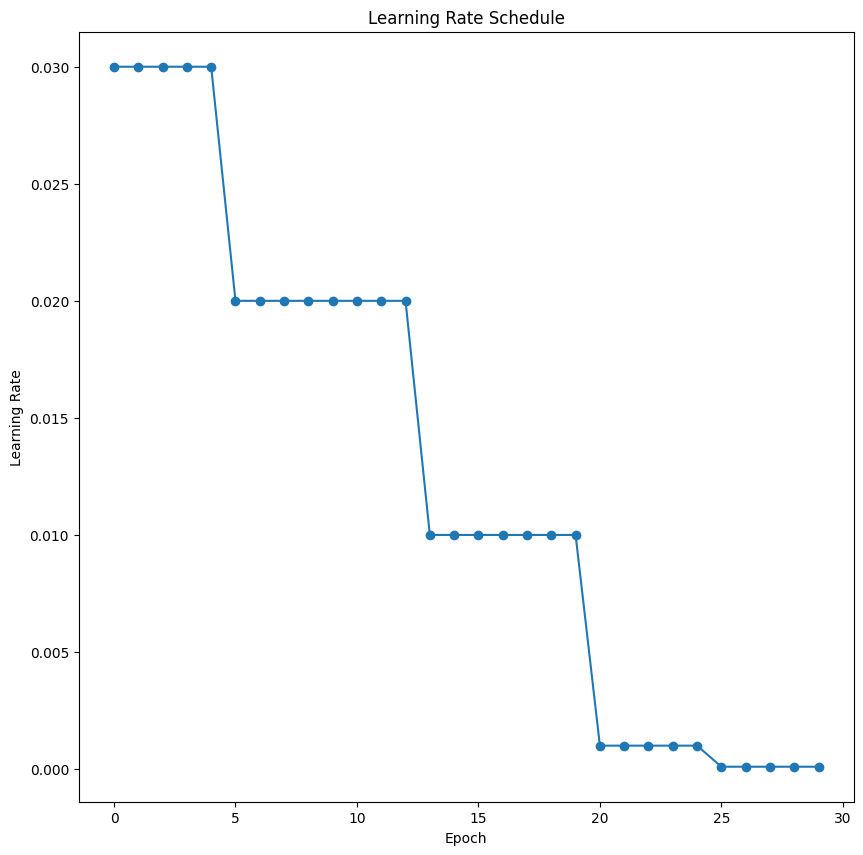

In [10]:
EPOCHS = 30
LRS    = [0.03]*5 + [0.02]*8 + [0.01]*7 + [0.001]*5 + [0.0001]*5

def lrfn(epoch):
    return LRS[epoch]

rng                = [i for i in range(EPOCHS)]
lr_y               = [lrfn(x) for x in rng]
plt.figure(figsize = (10, 10))
plt.plot(rng, lr_y, '-o')
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}". \
        format(lr_y[0], max(lr_y), lr_y[-1]))
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.show()

lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = False)

## Step 7 :  Model Definition
We use embedding layers for all label encoded categorical features. Then we concatenate all categorical embeddings with the numerical features. We create an MLP with two hidden layers. Our final output layer has one linear neuron and during training we use MSE loss with Adam optimizer.

In [11]:
def build_model(dropout_rate=0.3, use_batch_norm=True):
    # CATEGORICAL FEATURES
    x_input_cats = Input(shape=(len(CATS),))
    embs = []
    for j in range(len(CATS)):
        # Add regularization to embeddings
        e = tf.keras.layers.Embedding(
            CAT_SIZE[j],
            CAT_EMB[j],
            embeddings_regularizer=tf.keras.regularizers.l2(1e-4)
        )
        x = e(x_input_cats[:,j])
        x = tf.keras.layers.Flatten()(x)
        embs.append(x)
    
    # NUMERICAL FEATURES
    x_input_nums = Input(shape=(len(NUMS),))
    
    # Optional numerical feature normalization
    if use_batch_norm:
        x_input_nums = tf.keras.layers.BatchNormalization()(x_input_nums)
    
    # COMBINE
    x = tf.keras.layers.Concatenate(axis=-1)(embs + [x_input_nums])
    
    # Deeper architecture with residual connections
    def residual_block(x, units):
        skip = x
        x = Dense(units)(x)
        if use_batch_norm:
            x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
        x = Dense(units)(x)
        if use_batch_norm:
            x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)
        
        # If input and output dimensions don't match, transform skip connection
        if skip.shape[-1] != units:
            skip = Dense(units)(skip)
        
        return tf.keras.layers.Add()([x, skip])
    
    # Network architecture with residual blocks
    x = Dense(512, activation='relu')(x)
    if use_batch_norm:
        x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    
    # Final layers
    x = Dense(128, activation='relu')(x)
    if use_batch_norm:
        x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout_rate/2)(x)
    x = Dense(1, activation='linear')(x)
    
    model = Model(inputs=[x_input_cats, x_input_nums], outputs=x)
    
    return model

## Step 8: Train K Fold
We train our NN below. If you want to save the trained model weights, you can uncomment the commented lines below.

In [12]:
%%time

REPEATS = 3
FOLDS = 10

oof_nn  = np.zeros( len(train) )
pred_nn = np.zeros( len(test) )
models  = {}

# for r in range(REPEATS):
#     VERBOSE = r==0
#     print("#"*25)
#     print(f"### REPEAT {r+1} ###")
#     print("#"*25)
print(CATS)
print(NUMS)    

for fold in range(FOLDS):
    # fold = str(fold)
    
    X_train_cats = train[train["fold"]!=fold][CATS].values
    X_train_nums = train[train["fold"]!=fold][NUMS].values
    y_train      = train[train["fold"]!=fold]["y"].values
    y_train2     = train[train["fold"]!=fold]["efs"].values
    
    X_valid_cats = train[train["fold"]==fold][CATS].values
    X_valid_nums = train[train["fold"]==fold][NUMS].values
    y_valid      = train[train["fold"]==fold]["y"].values
    y_valid2     = train[train["fold"]==fold]["efs"].values
    x_valid_index = train[train["fold"]==fold]
    
    X_test_cats  = test[CATS].values
    X_test_nums  = test[NUMS].values

    
    #if VERBOSE:
    print(" ","#"*25)
    print(" ",f"### Fold {fold+1} ###")
    print(" ","#"*25)
    
    # TRAIN MODEL
    
    K.clear_session()
    model = build_model()
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001), 
                  loss="mean_squared_error",  
                 )
    v = 0
    model.fit([X_train_cats,X_train_nums], [y_train], 
              validation_data = ([X_valid_cats,X_valid_nums], [y_valid]),
              callbacks = [lr_callback],
              batch_size=512, epochs=EPOCHS, verbose=v)
    #model.save_weights(f'{directory}/NN_f{i}_r{r}.weights.h5')

    # INFER OOF
    oof_nn[x_valid_index.index] += model.predict([X_valid_cats,X_valid_nums], verbose=v, batch_size=512).flatten()
    # INFER TEST
    pred_nn += model.predict([X_test_cats,X_test_nums], verbose=v, batch_size=512).flatten()

    models[int(fold)] = model

pred_nn /= (FOLDS*REPEATS)

['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10']
['donor_age', 'age_at_hct']
  #########################
  ### Fold 1 ###
  ###############

I0000 00:00:1736961534.967872    3199 service.cc:145] XLA service 0x7c88b4003b60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736961534.967925    3199 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1736961534.967929    3199 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1736961547.064985    3233 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5', 728 bytes spill stores, 728 bytes spill loads

I0000 00:00:1736961547.376794    3231 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_4', 960 bytes spill stores, 920 bytes spill loads

I0000 00:00:1736961554.893861    3199 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
I0000 00:00:1736961564.360877    3261 asm_compiler.cc:369

  #########################
  ### Fold 2 ###
  #########################
  #########################
  ### Fold 3 ###
  #########################
  #########################
  ### Fold 4 ###
  #########################
  #########################
  ### Fold 5 ###
  #########################
  #########################
  ### Fold 6 ###
  #########################
  #########################
  ### Fold 7 ###
  #########################
  #########################
  ### Fold 8 ###
  #########################
  #########################
  ### Fold 9 ###
  #########################
  #########################
  ### Fold 10 ###
  #########################
CPU times: user 13min, sys: 17.3 s, total: 13min 18s
Wall time: 9min 37s


## Compute Overall Metric

In [13]:
from metric import score

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_nn
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for NN =",m)


Overall CV for NN = 0.6557183725208863


# Create Submission CSV

In [16]:
from scipy.stats import rankdata

sub = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv")
sub.prediction = rankdata(pred_nn)
sub.to_csv("submission.csv",index=False)
print("Sub shape:",sub.shape)
sub.head()

Sub shape: (3, 2)


,ID,prediction
0,28800,2.0
1,28801,3.0
2,28802,1.0


In [17]:
import pickle
with open('nn_exp_01.pkl', 'wb') as f:
    pickle.dump(models, f)

In [18]:
train['predictions'] = oof_nn
train.to_excel("nn_exp_01_oof.xlsx")

In [19]:
train

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time,fold,y,predictions
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0,0,0,-1.358108,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,42.356,3.0,-1.437594,-1.112600
1,1,1,0,1,0,1,1,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,1,1,0,1,0,1,1,1,0,0,1.952325,0,0,0,0.238463,0,1,0,1,0,1,1,0,0,1,1,0,0,0,0,1,0,1.0,4.672,7.0,1.479320,0.065108
2,2,0,0,0,0,1,1,0,0,0,0,0,0,0,2,0,0,1,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0.000000,0,0,0,-0.220605,0,2,0,2,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,19.793,6.0,-1.354672,-1.321212
3,3,2,0,1,0,1,1,0,0,0,0,0,0,0,3,0,0,1,0,1,0,0,0,0,0,0,1,1,0,3,0,1,1,1,0,0,-0.870869,0,0,0,0.216711,0,3,0,3,0,2,0,0,1,1,0,0,0,0,0,0,0,0.0,102.349,1.0,-1.497155,-0.023685
4,4,2,0,0,0,1,1,0,0,0,1,0,0,0,4,0,0,1,0,0,1,0,0,0,0,1,0,1,1,4,0,0,0,0,0,0,0.937392,0,0,0,-0.421908,0,4,0,0,0,3,2,0,0,1,1,1,0,0,0,0,0,0.0,16.223,4.0,-1.345944,-0.448739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28795,28795,7,3,4,0,1,1,0,0,0,1,0,0,2,3,0,2,1,0,1,0,0,0,0,0,1,1,1,0,4,0,2,0,3,0,0,-1.199870,1,0,0,0.589857,0,7,1,0,0,0,0,5,2,4,3,0,0,3,0,0,0,0.0,18.633,4.0,-1.351441,-0.062950
28796,28796,2,0,2,1,2,5,0,0,4,1,0,0,0,1,2,1,3,0,4,4,1,0,0,0,1,2,2,1,6,0,1,1,0,1,0,-0.769900,0,1,0,-0.973518,0,8,0,0,1,4,1,0,0,2,1,0,5,1,1,1,5,1.0,4.892,9.0,1.342926,0.118215
28797,28797,6,3,2,3,1,1,0,2,0,1,0,1,2,9,0,1,1,0,4,0,0,1,0,0,1,3,1,0,4,0,0,1,4,0,0,-1.303789,0,0,1,0.583662,0,3,1,0,0,4,8,0,2,2,0,0,0,3,0,0,0,0.0,23.157,2.0,-1.367980,0.175323
28798,28798,0,0,2,0,2,5,0,0,2,1,0,1,2,9,2,0,5,1,1,2,1,0,1,1,1,0,3,0,4,2,0,0,0,1,0,1.020265,1,1,1,-1.826161,1,2,0,3,1,5,2,0,0,1,1,1,4,0,1,0,4,0.0,52.351,9.0,-1.459520,-1.121162
